In [1]:
import pandas as pd
import warnings
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

warnings.filterwarnings('ignore')

url = "https://raw.githubusercontent.com/kevirui/challenge-telecom-x/refs/heads/ramaDev/data/data_tratada.csv"

data = pd.read_csv(url)

# Tratamiento y Codificación

In [2]:
data = data.drop(columns=['customerID', 'account.Charges.Total', 'Total.Day'])

```bash
data['customer.Partner'] = data['customer.Partner'].replace({'No':0, 'Yes':1}).astype(int)
data['customer.Dependents'] = data['customer.Dependents'].replace({'No':0, 'Yes':1}).astype(int)
data['account.PaperlessBilling'] = data['account.PaperlessBilling'].replace({'No':0, 'Yes':1}).astype(int)
```

```bash
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categoricas = ['customer.gender', 'account.Contract', 'account.PaymentMethod']

one_hot_enc = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), categoricas), remainder='passthrough')
data = one_hot_enc.fit_transform(data)
data = pd.DataFrame(data, columns=one_hot_enc.get_feature_names_out())
data.sample(5)
```

In [3]:
def preproceso(df):
    data = df.copy()

    # Diccionario de reemplazos para binarias
    reemplazos = {
        'Yes': 1,
        'No': 0,
        'No phone service': 0,
        'No internet service': 0
    }

    # Columnas binarias
    binarios = [
        'Churn', 'customer.Partner', 'customer.Dependents',
        'phone.PhoneService', 'phone.MultipleLines', 'internet.OnlineSecurity',
        'internet.OnlineBackup', 'internet.DeviceProtection',
        'internet.TechSupport', 'internet.StreamingTV',
        'internet.StreamingMovies', 'account.PaperlessBilling'
    ]

    # Columnas nominales
    nominales = ['customer.gender', 'account.Contract', 'account.PaymentMethod', 'internet.InternetService']

    # Procesar binarias
    for col in binarios:
        if col in data.columns:
            data[col] = data[col].replace(reemplazos).astype(int)

    # One-Hot Encoding para nominales
    data = pd.get_dummies(data, columns=nominales, drop_first=True)

    return data

data_procesada = preproceso(data)

In [4]:
data_procesada['Churn'].value_counts()

,count
Churn,
0,5174
1,1869


In [5]:
data_procesada['Churn'].value_counts(normalize=True)

,proportion
Churn,
0,0.73463
1,0.26537


Hay desbalance de clases en relación a la evasión

# Balanceo de datos

In [6]:
x, y = data_procesada.drop(columns=['Churn']), data_procesada['Churn']

In [7]:
from collections import Counter

print(sorted(Counter(y).items()))

[(0, 5174), (1, 1869)]


Existe desbalanceo de datos

( Aplicare under sampling )

In [8]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=5)
x_bal, y_bal = smote_enn.fit_resample(x, y)

In [9]:
print(sorted(Counter(y_bal).items()))

[(0, 2627), (1, 4132)]


# Normalización

In [10]:
data_procesada.describe().round(2)

,Churn,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.PaperlessBilling,account.Charges.Monthly
count,7043.00,7043.00,7043.00,7043.00,7043.00,7043.0,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00
mean,0.27,0.16,0.48,0.30,32.37,0.9,0.42,0.29,0.34,0.34,0.29,0.38,0.39,0.59,64.76
std,0.44,0.37,0.50,0.46,24.56,0.3,0.49,0.45,0.48,0.48,0.45,0.49,0.49,0.49,30.09
min,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.25
25%,0.00,0.00,0.00,0.00,9.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,35.50
50%,0.00,0.00,0.00,0.00,29.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,70.35
75%,1.00,0.00,1.00,1.00,55.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,89.85
max,1.00,1.00,1.00,1.00,72.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,118.75


Usaremos Random Forest - Decision Tree - KNNeighbors, por lo tanto normalizar no es necesario ya que no es sensible a los datos. Solamente para KNNeighbots.

## Normalizar para KNNeighbors

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_bal_norm = scaler.fit_transform(x_bal)

# Analisis de Correlación

In [12]:
churnCorr = data_procesada.corr()['Churn']
churnCorr = churnCorr.drop('Churn')

churnCorr = churnCorr.abs().sort_values(ascending=False)

print("Variables con las correlaciones más fuertes con 'Churn' (ordenadas por valor absoluto):")
display(churnCorr)

Variables con las correlaciones más fuertes con 'Churn' (ordenadas por valor absoluto):


,Churn
customer.tenure,0.352229
internet.InternetService_Fiber optic,0.308020
account.Contract_Two year,0.302253
account.PaymentMethod_Electronic check,0.301919
internet.InternetService_No,0.227890
account.Charges.Monthly,0.193356
account.PaperlessBilling,0.191825
account.Contract_One year,0.177820
internet.OnlineSecurity,0.171226
internet.TechSupport,0.164674


# Análisis Dirigido

## Tiempo de Contrato x Cancelación

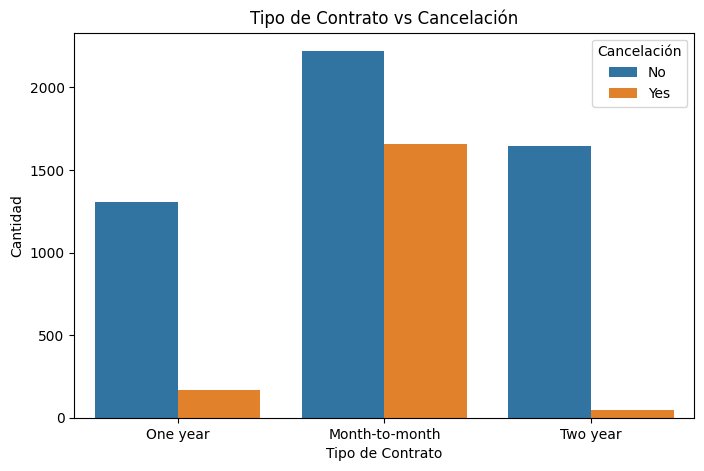

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(x='account.Contract', hue='Churn', data=data)
plt.title('Tipo de Contrato vs Cancelación')
plt.xlabel("Tipo de Contrato")
plt.ylabel("Cantidad")
plt.legend(title='Cancelación')
plt.show()

- Los tipos de contrato mes a mes indican que son mas propensos a cancelar
- En cambio los tipos de contrato cada 2 años son menos propensos a cancelar

## Gasto total x Cancelación

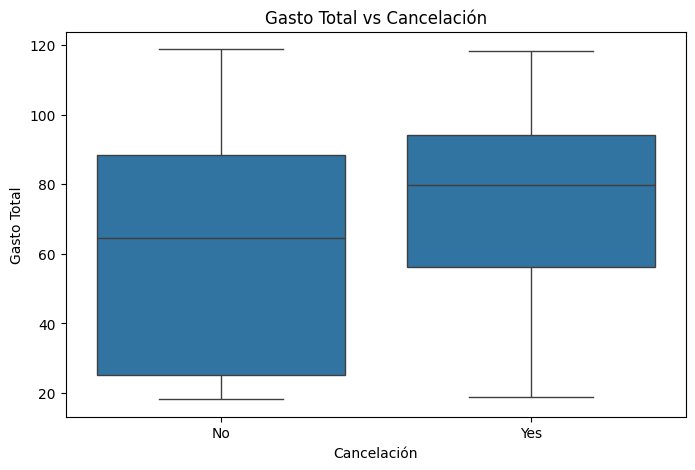

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='account.Charges.Monthly', data=data)
plt.title('Gasto Total vs Cancelación')
plt.xlabel("Cancelación")
plt.ylabel("Gasto Total")
plt.show()

- El promedio de gastos totales de los que cancelan tienen un gasto mayor que a los minimos habituales.
- Muchas de las cancelaciones cuentan con los gastos rondando en 80 y 60

# Entrenamientos de modelos

## Separación de datos


In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_bal, y_bal, test_size=0.2, random_state=5)

## Entrenamiento modelo baseline

In [16]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(x_train, y_train)

dummy.score(x_test, y_test)

0.613905325443787

## Entrenamiento Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=5)
forest.fit(x_train, y_train)

forest.score(x_test, y_test)

0.9452662721893491

## Entrenamiento Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier

arbol = DecisionTreeClassifier(random_state=5)
arbol.fit(x_train, y_train)

arbol.score(x_test, y_test)

0.9304733727810651

## Entrenamiento Modelo KNN

### Normalización

In [19]:
from sklearn.preprocessing import MinMaxScaler

normalizacion = MinMaxScaler()

x_train_bal_norm = normalizacion.fit_transform(x_train)

x_test_norm = normalizacion.transform(x_test)

pd.DataFrame(x_train_bal_norm)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.0,0.0,0.0,0.013889,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.320584,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.805556,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.064922,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.020131,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.162506,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.013889,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.609461,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5402,1.0,0.0,0.0,0.541667,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.779064,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5403,0.0,1.0,0.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.995471,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
5404,1.0,1.0,0.0,0.222222,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.826947,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
5405,0.0,1.0,1.0,0.166667,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.071968,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
# Train the KNN model using the normalized training data
knn.fit(x_train_bal_norm, y_train)

# Evaluate the model using the normalized test data
knn.score(x_test_norm, y_test)

0.9215976331360947

# Evaluar Modelos

In [21]:
from sklearn.metrics import classification_report

# Evaluar Dummy Classifier
dummy_pred = dummy.predict(x_test)
print("Dummy Classifier reporte:")
print(classification_report(y_test, dummy_pred))

# Evaluar Random Forest Classifier
forest_pred = forest.predict(x_test)
print("Random Forest Classifier reporte:")
print(classification_report(y_test, forest_pred))

# Evaluar Decision Tree Classifier
arbol_pred = arbol.predict(x_test)
print("Decision Tree Classifier reporte:")
print(classification_report(y_test, arbol_pred))

# Evaluar KNN Classifier (usando datos de test normalizados)
knn_pred = knn.predict(x_test_norm)
print("KNN Classifier reporte:")
print(classification_report(y_test, knn_pred))

Dummy Classifier reporte:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       522
           1       0.61      1.00      0.76       830

    accuracy                           0.61      1352
   macro avg       0.31      0.50      0.38      1352
weighted avg       0.38      0.61      0.47      1352

Random Forest Classifier reporte:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       522
           1       0.95      0.97      0.96       830

    accuracy                           0.95      1352
   macro avg       0.95      0.94      0.94      1352
weighted avg       0.95      0.95      0.95      1352

Decision Tree Classifier reporte:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       522
           1       0.94      0.95      0.94       830

    accuracy                           0.93      1352
   macro avg       0.93      0.93 

## Probar otras tecnicas de balanceo

### Partimos desde el dataset original

In [22]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

### Definir las técnicas de balanceo a probar

In [24]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Sin balanceo: se manejará con class_weight en el modelo
no_balance = None

# SMOTEENN
smoteenn = SMOTEENN(random_state=42)

# SMOTETomek
smotetomek = SMOTETomek(random_state=42)

# SMOTE con sampling_strategy ajustado
smote_adj = SMOTE(sampling_strategy=0.8, random_state=42)

# UnderSampling + SMOTE
under_then_smote = [('under', RandomUnderSampler(sampling_strategy=0.8, random_state=42)),
                    ('smote', SMOTE(random_state=42))]

## Evaluar y comparar entre tecnicas de balanceo

In [25]:
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline

strategies = {
    "No balance (class_weight)": no_balance,
    "SMOTEENN": smoteenn,
    "SMOTETomek": smotetomek,
    "SMOTE adj": smote_adj
}

for name, strategy in strategies.items():
    if strategy is None:
        model = RandomForestClassifier(class_weight='balanced', random_state=42)
        model.fit(x_train, y_train)
    else:
        pipe = Pipeline([
            ('resample', strategy),
            ('model', RandomForestClassifier(random_state=42))
        ])
        pipe.fit(x_train, y_train)
        model = pipe

    y_pred = model.predict(x_test)
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))


--- No balance (class_weight) ---
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

--- SMOTEENN ---
              precision    recall  f1-score   support

           0       0.91      0.71      0.79      1035
           1       0.50      0.80      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.75      1409

--- SMOTETomek ---
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1035
           1       0.57      0.60      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.72      0.71      1409
weig

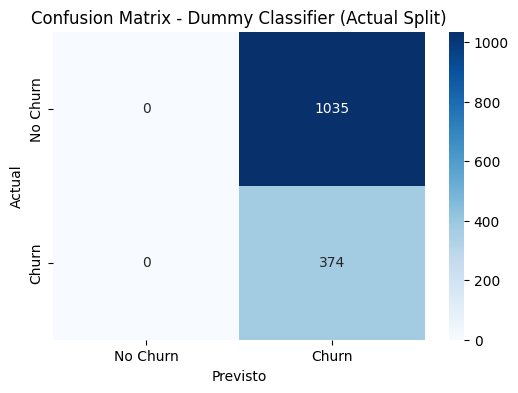

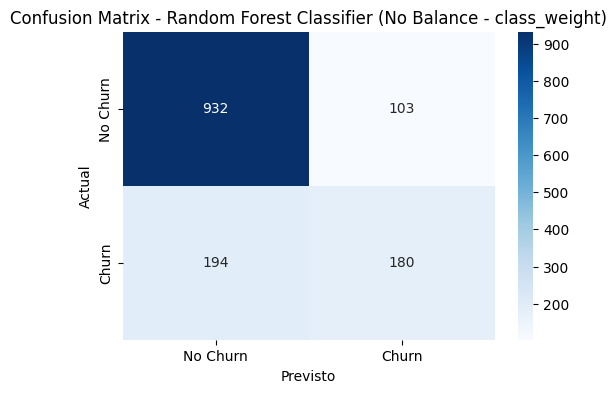

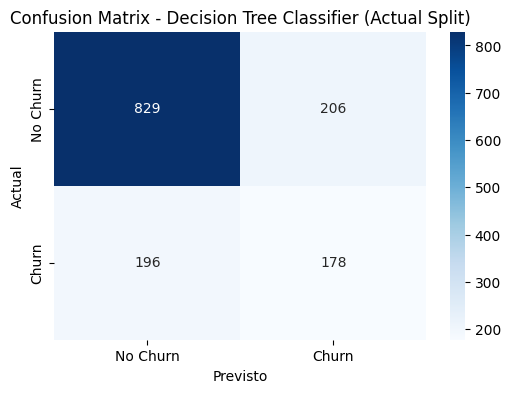

In [32]:
from sklearn.metrics import confusion_matrix

# Re-generar predicciones usando el actual x_test y los modelos apropiados
dummy_pred = dummy.predict(x_test)

# Random Forest Classifier ( sin balance )
forest_no_balance = RandomForestClassifier(class_weight='balanced', random_state=42)
forest_no_balance.fit(x_train, y_train)
forest_pred = forest_no_balance.predict(x_test)

# Decision Tree Classifier ( entrenado con los datos balanceados del spli anterior )
arbol_new = DecisionTreeClassifier(random_state=5)
arbol_new.fit(x_train, y_train)
arbol_pred = arbol_new.predict(x_test)

# Confusion Matrix para Dummy Classifier
cm_dummy = confusion_matrix(y_test, dummy_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dummy, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Dummy Classifier (Actual Split)')
plt.xlabel('Previsto')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix para Random Forest Classifier (Sin balance con class_weight en el actual split)
cm_forest = confusion_matrix(y_test, forest_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_forest, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Random Forest Classifier (No Balance - class_weight)')
plt.xlabel('Previsto')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix para Decision Tree Classifier ( en el split actual )
cm_arbol = confusion_matrix(y_test, arbol_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_arbol, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Decision Tree Classifier (Actual Split)')
plt.xlabel('Previsto')
plt.ylabel('Actual')
plt.show()

# Nota: El trazado para KNN y otros modelos equilibrados del bucle anterior si requiriría
# Capturando esos modelos entrenados durante el ciclo de evaluación.

# Evaluar variables importantes en el modelo seleccionado ( Random Forest )

Top 10 features mas importantes de Random Forest:


,feature,importancia
3,customer.tenure,0.234250
13,account.Charges.Monthly,0.212259
16,account.Contract_Two year,0.065629
20,internet.InternetService_Fiber optic,0.046322
18,account.PaymentMethod_Electronic check,0.042397
15,account.Contract_One year,0.035644
14,customer.gender_Male,0.032017
21,internet.InternetService_No,0.030306
12,account.PaperlessBilling,0.028794
6,internet.OnlineSecurity,0.027989


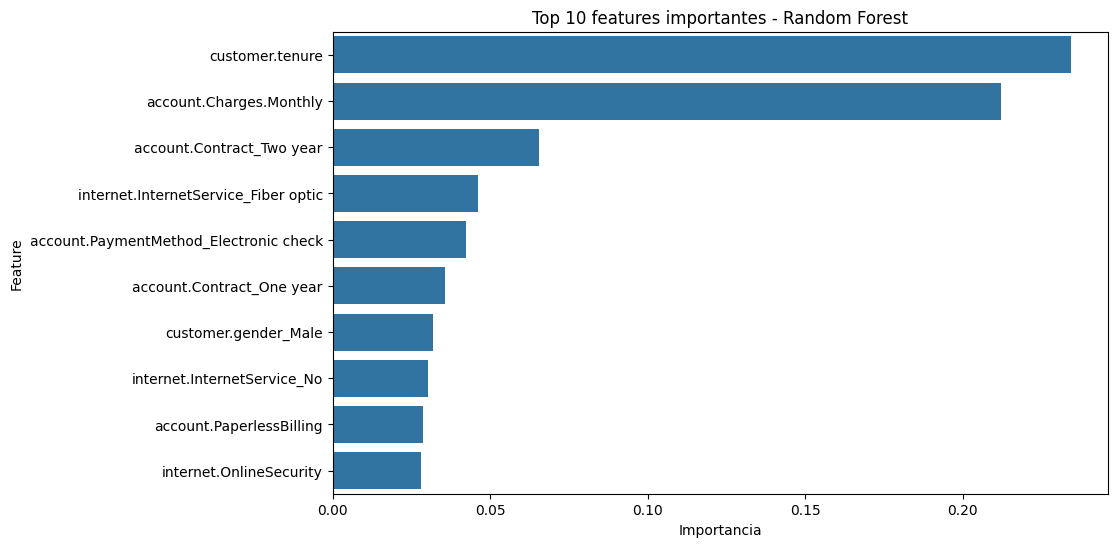

In [33]:
# Para el Random Forest entrenado con class_weight en el split actual:
importances = forest_no_balance.feature_importances_

# Obtener los nombres de los features
feature_names = x_train.columns

# Crear un dataframe para mejor visualización
feature_importances_df = pd.DataFrame({'feature': feature_names, 'importancia': importances})

# Filtrar los valores por importancia
feature_importances_df = feature_importances_df.sort_values('importancia', ascending=False)

# Visualizar las features top
print("Top 10 features mas importantes de Random Forest:")
display(feature_importances_df.head(10))

# Visualizar la importancia de las features
plt.figure(figsize=(10, 6))
sns.barplot(x='importancia', y='feature', data=feature_importances_df.head(10))
plt.title('Top 10 features importantes - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.show()

# Conclusión

## Informe detallado sobre el análisis de la pérdida de clientes

A partir del análisis realizado, este informe identifica los factores clave que influyen en la pérdida de clientes y propone estrategias para retenerlos.

### Factores clave de la rotación

A partir de la importancia de las características del modelo Random Forest, se identificaron las siguientes variables como los predictores más significativos de la pérdida de clientes:

*   **Customer Tenure:** La antigüedad de un cliente en la empresa es un buen indicador. Los clientes con menos antigüedad parecen más propensos a cambiar de empresa.
*   **Monthly Charges:** Las cuotas mensuales más elevadas se asocian a una mayor probabilidad de abandono. Esto sugiere que los clientes pueden marcharse debido al coste de los servicios.
*   **Contract Type (Dos años vs. Mes a Mes):** Los clientes con contratos mensuales tienen una tasa de rotación significativamente mayor que los que tienen contratos de uno o dos años. Esto pone de relieve la importancia de los compromisos a largo plazo.
*   **Internet Service Type (Fiber Optic vs. No Internet Service):** Los clientes con servicio de Internet de fibra óptica parecen tener un índice de rotación más alto que los que no tienen servicio de Internet. Esto podría deberse a factores como el precio, la calidad del servicio o la disponibilidad de alternativas. Por el contrario, los clientes sin servicio de Internet son menos propensos a cambiar de operador, lo que podría indicar que utilizan servicios telefónicos básicos con menor riesgo de pérdida de clientes.
*   **Payment Method (Electronic Check):** Los clientes que utilizan cheques electrónicos como método de pago muestran una mayor propensión a cambiar de proveedor. Esto podría deberse a la facilidad para cambiar de proveedor al utilizar pagos electrónicos o a posibles problemas con este método de pago.
*   **Paperless Billing:** Los clientes con facturación electrónica parecen tener un mayor índice de rotación. Esto podría ser un indicador indirecto relacionado con la familiaridad con la tecnología o la preferencia por las interacciones en línea, lo que podría hacerles más proclives a cambiar de proveedor.

Otros factores destacables, aunque con una importancia ligeramente inferior, son:
* Seguridad en línea, asistencia técnica, copias de seguridad en línea, protección de dispositivos, televisión en streaming y películas en streaming: la presencia o ausencia de estos servicios de Internet también influye, lo que sugiere que los paquetes de servicios de los clientes influyen en su decisión de cambiar de proveedor.
* Dependientes y tercera edad: Estos factores demográficos también muestran cierta correlación con el abandono.
* Pareja y sexo: Estos factores parecen tener menos influencia en el abandono que las variables relacionadas con el servicio y contractuales.

### Resumen del rendimiento de los modelos

Hemos evaluado varios modelos y técnicas de equilibrio. El clasificador Random Forest, especialmente cuando se entrenó para corregir el desequilibrio de clases (mediante técnicas de equilibrado o utilizando `weight_class`), mostró un gran rendimiento en la predicción de bajas en comparación con el clasificador ficticio de referencia. Las matrices de confusión proporcionaron una imagen más clara de la eficacia con la que cada modelo identificó correctamente a los clientes que habían abandonado y a los que no. El modelo Random Forest mostró un buen equilibrio entre `precision` y `recall` para ambas clases.

### Estrategias de retención propuestas

Sobre la base de los factores identificados, a continuación se proponen algunas estrategias de retención:

* Teniendo en cuenta que los clientes con menor permanencia son más propensos a cambiar de proveedor, hay que centrarse en ofrecer excelentes experiencias de incorporación y programas de compromiso temprano para fidelizar a los clientes desde el principio.
* **Revisar los precios y ofrecer valor:** Abordar el impacto de las cuotas mensuales revisando las estrategias de precios, ofreciendo paquetes competitivos o servicios de valor añadido que justifiquen el coste, especialmente para los clientes que más gastan.
* **Promueva los contratos a largo plazo:** Anime activamente a los clientes a pasar de contratos mensuales a contratos a más largo plazo ofreciéndoles incentivos, descuentos o ventajas exclusivas. Destaque la estabilidad y el ahorro potencial de los compromisos a largo plazo.
* **Mejorar el servicio de fibra óptica y abordar los problemas de pago con cheque electrónico:** Investigar posibles problemas o insatisfacción entre los clientes de fibra óptica y los que utilizan cheques electrónicos. Esto podría implicar mejorar la calidad del servicio, solucionar problemas de pago u ofrecer métodos de pago alternativos.
* Para los clientes con un servicio de Internet básico o sin él, explore las oportunidades de vender servicios adicionales que puedan aumentar su compromiso y reducir el riesgo de pérdida de clientes. Para los clientes con varios servicios, asegúrese de que son conscientes del valor total de su paquete.
* **Campañas de retención específicas:** Desarrolle campañas de retención específicas basadas en los factores de riesgo identificados. Por ejemplo, ofrezca promociones especiales o asistencia personalizada a los clientes con periodos de permanencia más cortos, cargos mensuales elevados o contratos mensuales.
* **Soporte y comunicación proactivos:** Implantar un soporte proactivo para abordar los posibles problemas antes de que provoquen la pérdida de clientes. Mantener una comunicación clara y coherente con los clientes, especialmente en relación con los cambios de servicio, la facturación o las nuevas ofertas.

Al centrarse en estas áreas clave, la empresa puede desarrollar estrategias más eficaces para retener a los clientes valiosos y reducir la rotación.